In [1]:
from simformer import *
import matplotlib.pyplot as plt
import matplotlib.animation

import numpy as np
import torch

%matplotlib inline

In [2]:
# Load data
x = np.load("data/x.npy")
theta = np.load("data/theta.npy")

data = torch.tensor(np.concatenate([theta, x], axis=1), dtype=torch.float32)

In [3]:
# Define beta schedule
T = 300
t = torch.linspace(0, 1, T)

simformer = Simformer(T, data.shape)

/Users/bguenes/miniconda3/envs/simformer/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
simformer.sde.sigma = 25

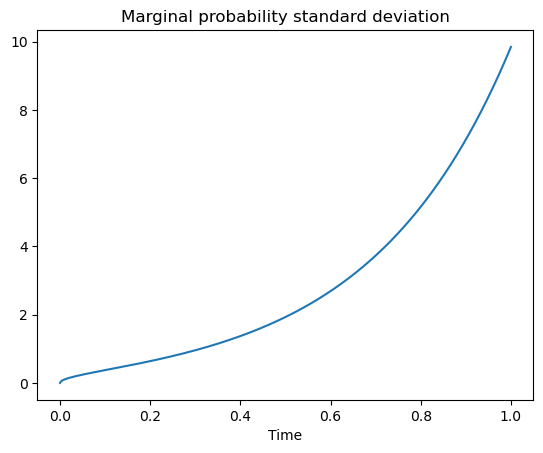

In [5]:
plt.plot(t, simformer.sde.marginal_prob_std(t))
plt.title("Marginal probability standard deviation")
plt.xlabel("Time")
plt.show()

# Animate Diffusion Process
Diffusion process to create the data for score training.

In [6]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, T)
color = ['red', 'blue', 'green', 'purple', 'orange', 'black']

def animate(i):
    data_t = simformer.forward_diffusion_sample(data[:,:6], t[i])
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-5,15), density=True, alpha=0.5, color=color[n])
    plt.xlim([-5,15])
    plt.ylim([0,1])
    plt.title(f"t={int(i)}")


ani = matplotlib.animation.FuncAnimation(fig, animate, frames=299)

writer = matplotlib.animation.PillowWriter(fps=20,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('../plots/theta_to_noise.gif', writer=writer)


In [7]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, T)

def animate2(i):
    data_t = simformer.forward_diffusion_sample(data[:,7:], t[i])
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-2,2), density=True, alpha=0.5)
    plt.xlim([-2,2])
    plt.ylim([0,2.5])
    plt.title(f"t={int(i)}")

ani2 = matplotlib.animation.FuncAnimation(fig, animate2, frames=299) 

writer = matplotlib.animation.PillowWriter(fps=20,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani2.save('../plots/x_to_noise.gif', writer=writer)

# Transformer forward pass

In [9]:
score = simformer.forward_transformer(data[:10], torch.ones(data[:10].shape[0],1)*10, condition_mask=torch.ones_like(data[:10]))

In [10]:
score.shape

torch.Size([10, 14, 1])

In [11]:
score

tensor([[[ 2.5448e+13],
         [ 2.3418e+12],
         [ 1.2244e+13],
         [ 3.2735e+12],
         [ 4.9857e+12],
         [-8.4620e+12],
         [-4.1683e+12],
         [-7.4208e+12],
         [ 1.4981e+12],
         [ 4.1489e+12],
         [-8.0714e+12],
         [ 6.2548e+12],
         [-1.9152e+13],
         [ 3.2424e+13]],

        [[ 1.2891e+13],
         [ 2.2417e+13],
         [ 1.7906e+13],
         [ 1.2200e+13],
         [ 3.6541e+13],
         [ 1.5420e+13],
         [-1.3469e+13],
         [ 1.8591e+13],
         [ 2.2453e+13],
         [ 2.7268e+12],
         [-7.2282e+11],
         [ 1.2289e+13],
         [-1.2040e+13],
         [ 1.0638e+13]],

        [[ 2.3900e+13],
         [ 3.7485e+13],
         [ 2.5699e+13],
         [ 1.3094e+13],
         [ 1.1130e+13],
         [-6.0298e+12],
         [-2.5444e+12],
         [ 2.2622e+12],
         [ 1.3779e+13],
         [ 1.9784e+13],
         [ 9.4148e+12],
         [ 4.7639e+12],
         [ 6.7846e+12],
         [ 1